In [1]:
import numpy as np                               # работа с векторами и матрицами
import pandas as pd                              # таблицы и операции над данными
import matplotlib.pyplot as plt                  # графики
import seaborn as sns                            # еще графики

from dateutil.relativedelta import relativedelta # для комфортной работы с датами
from scipy.optimize import minimize              # позволяет минимизировать функции

import statsmodels.formula.api as smf            # всякая статистика и эконометрика
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # немножко функций для удобства
from tqdm import tqdm_notebook

import warnings                                  # чтобы никто не мешал бесчинствам с кодом
warnings.filterwarnings('ignore')

%matplotlib inline


# метрики качества

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

C:\Users\vvsol\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
currency = pd.read_csv('data/currency.csv', index_col=['Time'], parse_dates=['Time'])

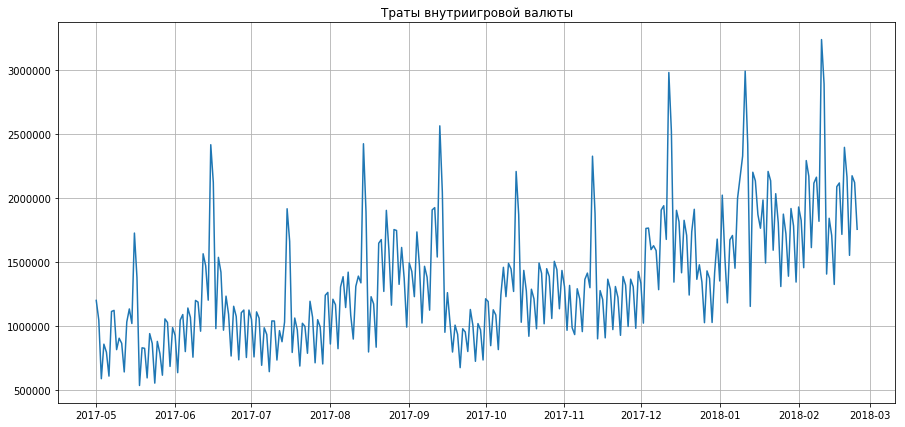

In [3]:
plt.figure(figsize=(15, 7))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title('Траты внутриигровой валюты')
plt.grid(True)
plt.show()

In [4]:
# Для прогноза будем использовать mape
# Оставим 10% выборки для теста

test=currency.iloc[270:,:]
train=currency.iloc[:270,:]
train['trend']=list(range(0,270))

Надо верхнеуровнево посмотреть есть ли тренд в данных. Для этого можно просто фитнуть регрессию на тренд.

In [5]:
model=smf.ols('GEMS_GEMS_SPENT~trend',data=train)
result=model.fit()
result.summary()
# видим в наших данных есть тренд (коэффициент у тренда значим и сама регрессия значима тоже)
# сезонность же видна на графике прям сама, поэтому осмысленно применять фильтр Хольта-Винтерса

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        GEMS_GEMS_SPENT   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     101.2
Date:                Sun, 23 Sep 2018   Prob (F-statistic):           2.08e-20
Time:                        15:51:45   Log-Likelihood:                -3848.8
No. Observations:                 270   AIC:                             7702.
Df Residuals:                     268   BIC:                             7709.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8.855e+05   4.57e+04     19.360      0.000    7.95e+05    9.76e+05
trend       2960.1581    294.216     10.061      0.000    2380.889    3539.427
==============================================================================
Omnibus:                       56.885   Durbin-Watson:                   1.211
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.672
Skew:                           1.140   Prob(JB):                     2.27e-22
Kurtosis:                       4.914   Cond. No.                         310.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
from sklearn.model_selection import TimeSeriesSplit # здорово, когда всё реализовано до тебя
from HoltWinters import HoltWinters                 # код большой, поэтому лежит отдельно

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # вектор ошибок
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [7]:
slen = 30 # месячная сезонность
# инициализируем значения параметров
x = [0, 0, 0] 

# Минимизируем функцию потерь с ограничениями на параметры
opt = minimize(timeseriesCVscore, x0=x, 
               args=(train.GEMS_GEMS_SPENT, mean_absolute_percentage_error, slen), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)




0.037400820473832475 0.005390174173128148 0.0


In [8]:
model = HoltWinters(train.GEMS_GEMS_SPENT, slen = slen, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 30, scaling_factor = 3)
model.triple_exponential_smoothing()
preds=np.array(model.result[-30:])
mean_absolute_percentage_error(test.GEMS_GEMS_SPENT.values,preds)

7.344342951617929

Ошибка получилась 7% просто при использовании фильтра. Достаточно неплохо. Теперь попробуем оценить наши данные аримой.

In [9]:
model=smf.ols('GEMS_GEMS_SPENT~trend',data=train)
result=model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        GEMS_GEMS_SPENT   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     101.2
Date:                Sun, 23 Sep 2018   Prob (F-statistic):           2.08e-20
Time:                        15:51:48   Log-Likelihood:                -3848.8
No. Observations:                 270   AIC:                             7702.
Df Residuals:                     268   BIC:                             7709.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8.855e+05   4.57e+04     19.360      0.000    7.95e+05    9.76e+05
trend       2960.1581    294.216     10.061      0.000    2380.889    3539.427
==============================================================================
Omnibus:                       56.885   Durbin-Watson:                   1.211
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.672
Skew:                           1.140   Prob(JB):                     2.27e-22
Kurtosis:                       4.914   Cond. No.                         310.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

После построения простой модели у нас остались остатки - по сути мы детрендировали ряд. Посмотрим на остатки.

In [10]:
resid=result.resid

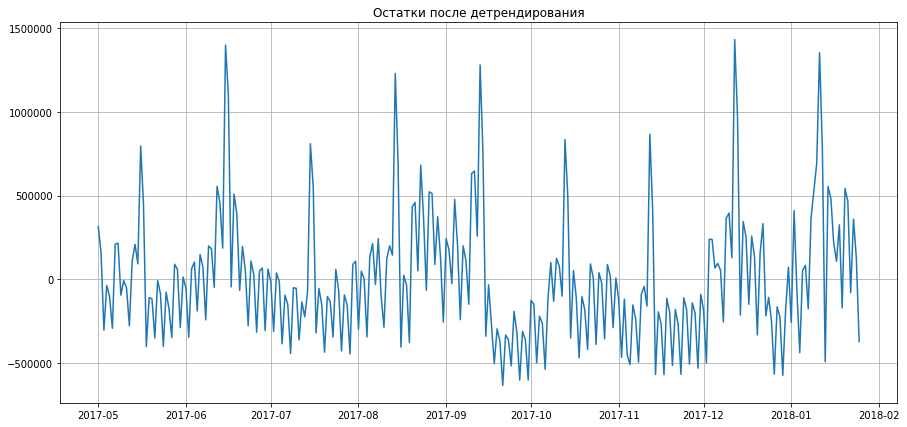

In [11]:
plt.figure(figsize=(15, 7))
plt.plot(resid)
plt.title('Остатки после детрендирования')
plt.grid(True)
plt.show()

In [12]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])
        plt.tight_layout()

Критерий Дики-Фуллера: p=0.001607


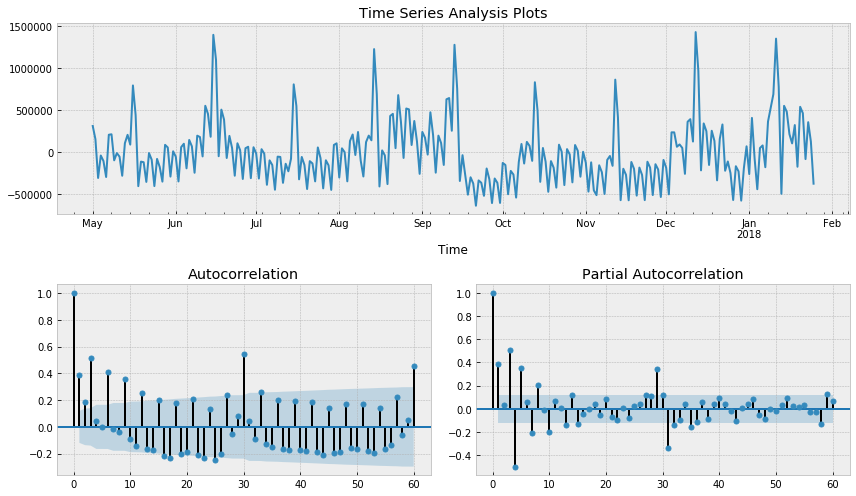

In [13]:
tsplot(resid, lags=60)
# Мы видим, что ряд даже похож на стационарный. Теперь нам надо убрать сезонность

In [14]:
def optimizeSARIMA(series,parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding BIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # try except нужен, потому что на некоторых наборах параметров модель не обучается
        try:
            model=sm.tsa.statespace.SARIMAX(series, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except Exception as e:
            continue

        results.append([param, model.bic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'bic']
    # сортируем по возрастанию, чем меньше критерий AIC, тем лучше
    result_table = result_table.sort_values(by='bic', ascending=True).reset_index(drop=True)
    
    return result_table

In [15]:
# зададим ограничения на возможные значения параметров для перебора
ps = range(0, 5)
d=0 # тут мы уверены, не дифференцировали ряд
qs = range(0, 5)

Ps = range(0, 2)
D=1 # здесь тоже уверены, сезонное дифференцирование скорее всего будет одно
Qs = range(0, 2)
s = 30

# создадим лист с возможными параметрами и посчитаем его длину
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

100

In [16]:
%%time
result_table = optimizeSARIMA(resid,parameters_list, d, D, s)

HBox(children=(IntProgress(value=0), HTML(value='')))


Wall time: 5min 12s


In [17]:
p, q, P, Q = result_table.parameters[0]
arima_model=sm.tsa.statespace.SARIMAX(resid, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)

Критерий Дики-Фуллера: p=0.000012


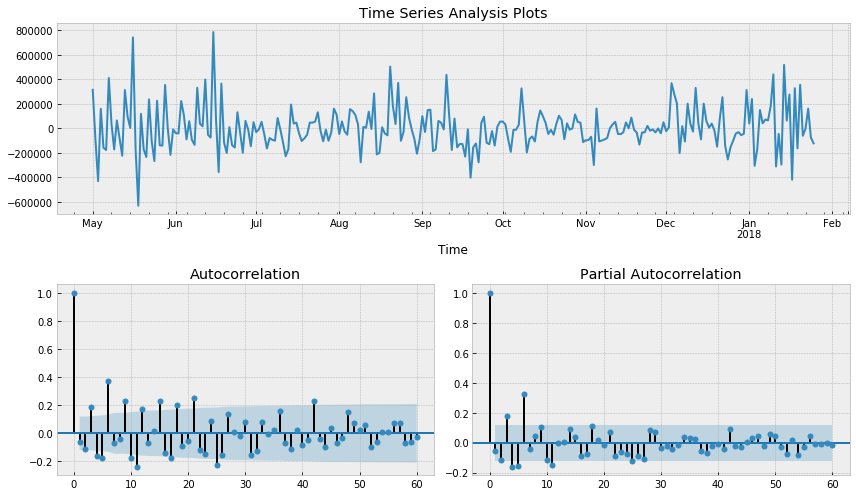

In [18]:
tsplot(arima_model.resid, lags=60)

In [19]:
# Посмотрим попробуем теперь все собрать
# Помним,что ряд у нас имеет трендовую и аримовскую часть
preds_arima=arima_model.predict((270-p+1),300)[p:]
trend_test=np.arange(270,300)*result.params['trend']
total_preds=preds_arima+trend_test+result.params['Intercept']
mean_absolute_percentage_error(test.GEMS_GEMS_SPENT.values,total_preds.values)

22.995234222430653

Видим, что мы уже достаточно долго копаемся в моделях и пытаемся ее зафитить, а результат пока не очень.
Но мы не отчаиваемся)) 

Теперь попробуем сложить 2 подхода -с помощью фильтра и с помощью модели арима.

In [32]:
model = HoltWinters(train.GEMS_GEMS_SPENT, slen = slen, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 30, scaling_factor = 3)
model.triple_exponential_smoothing()
preds_holt=np.array(model.result[-30:])# остаток непрогнозируемый фильтром . По сути из ряда достали тренд и сезонность.
#mean_absolute_percentage_error(test.GEMS_GEMS_SPENT.values,preds)

In [33]:
resid=train.GEMS_GEMS_SPENT.values-model.result[0:270]

Критерий Дики-Фуллера: p=0.010133


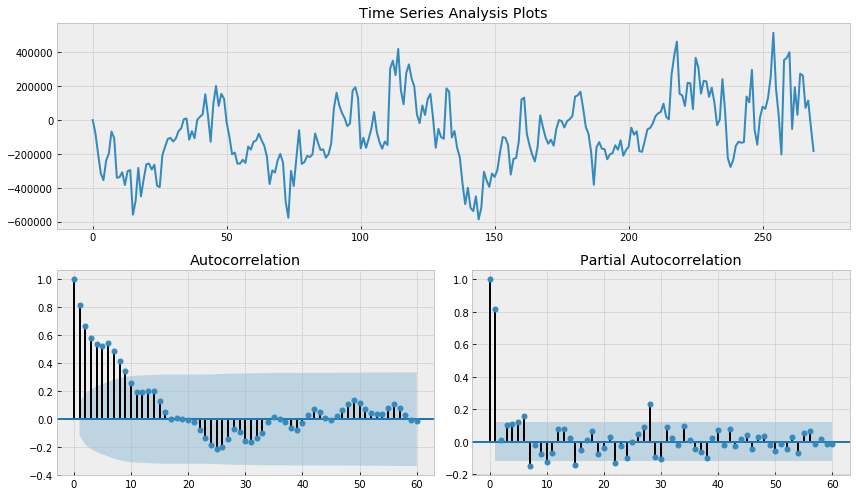

In [34]:
tsplot(resid, lags=60)

In [35]:
# зададим ограничения на возможные значения параметров для перебора
ps = range(0, 3)
d=0 # тут мы уверены, не дифференцировали ряд
qs = range(0, 3)

Ps = range(0, 3)
D=1 # здесь тоже уверены, сезонное дифференцирование скорее всего будет одно
Qs = range(0, 3)
s = 20 # смотрим глазами на график

# создадим лист с возможными параметрами и посчитаем его длину
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

81

In [36]:
%%time
result_table = optimizeSARIMA(resid,parameters_list, d, D, s)

HBox(children=(IntProgress(value=0, max=81), HTML(value='')))


Wall time: 1min 59s


In [37]:
p, q, P, Q = result_table.parameters[0]
arima_model=sm.tsa.statespace.SARIMAX(resid, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
preds_arima=arima_model.predict((270-p+1),300)[p:]
predicton=preds_holt+preds_arima
mean_absolute_percentage_error(test.GEMS_GEMS_SPENT.values,predicton)

7.051792969469102

Получили небольшое увелечение прогноза относительно чистого Хольта Винтерсе. Для такой точности прогноза уже достаточно неплохое увеличение. Посмотрим насколько все там красиво по графикам.

Критерий Дики-Фуллера: p=0.000286


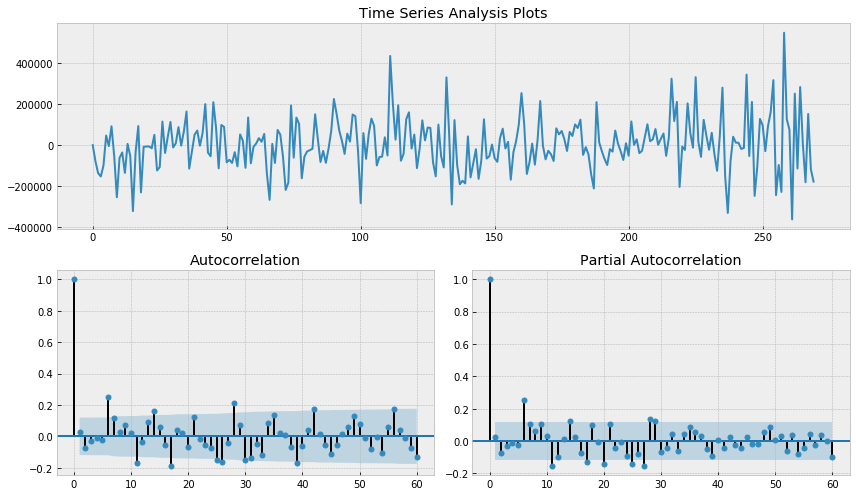

In [39]:
tsplot(arima_model.resid, lags=60)

По графика мне кажется, что можно добавить еще один лаг в ar и ma часть. (значимы четные лаги по обоим функция)
Посмотрим.

In [53]:
p, q, P, Q = result_table.parameters[0]
arima_model=sm.tsa.statespace.SARIMAX(resid, order=((p+1), d, 2), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
preds_arima=arima_model.predict((270-p+1),300)[p:]
predicton=preds_holt+preds_arima
mean_absolute_percentage_error(test.GEMS_GEMS_SPENT.values,predicton)

6.729888563674254

По сути получаем наш итоговый прогноз. Видим,что наши долгие мучения не так сильно добавили нам точности-не всегда это оправдано.
Также можно добавить для прогнозирования остатка более сложные методы машинного обучения-например бустинг, нейронные сети.
Как мы увидели-если в данных явно тренд и сезонность, то наш фильтр хольта-винтерса хорошо работает и превзойти его непростая задача.

В данном случае мы делаем достаточно жесткий прогноз-на 30 шагов вперед.Такой прогноз достаточно сложно делать, модель должна обладать хорошей прогностической способностью.Но мы всегда можем дообучать нашу модель прошлой информацией и делать шаг вперед и так далее.
Такой подход называется обучением в скользящем окне. У нас появляется дополнительный гипер параметр-n. Сколько информации в окне использовать для каждого следующего шага.
Такой подход более вычеслительно сложный. И если вам важно вытащить всю возможную точность из ваших данных, то можно использовать его.